In [1]:
#preprocess
import numpy as np
from sklearn import tree
import pydot	# It requires installing pydot and graphviz
import matplotlib.pyplot as plt
import pandas as pd
import re

#read file
df1 = pd.read_csv('googleplaystore.csv')
df1 = df1.drop(columns = ['Genres','Current Ver'])
df1 = df1.dropna(subset = ['Android Ver'])
df1 = df1.drop(columns = ['Android Ver'])
#Rating: fill nan with mean
df1['Rating'] = df1['Rating'].fillna(df1['Rating'].mean()).round(1)

#Size: remove 'M' and 'k' then divide 1000
df1['Size'] = df1['Size'].map(lambda x: x.rstrip('M'))
df1['Size'] = df1['Size'].replace("Varies with device","NaN")
for i in range(df1.iloc[:,0].size):
    if df1.iloc[i,4].rfind('k')>0:
        df1.iloc[i,4] = df1.iloc[i,4].rstrip('k')
        df1.iloc[i,4] = float(df1.iloc[i,4])
        df1.iloc[i,4] = df1.iloc[i,4]/1000
    df1.iloc[i,5] = re.sub('[,+]', '',df1.iloc[i,5])  #Installs: remove ','
#ignore the outliers and then use the mean to fill in NaN
df1['Size'] = df1['Size'].astype(float)
size_mean = df1['Size'].mean()
size_sd = df1['Size'].std()
arr = np.array(df1['Size'])
final_list = [x for x in arr if (x > size_mean - 2 * size_sd)]
final_list = [x for x in arr if (x < size_mean + 2 * size_sd)]
df1['Size'] = df1['Size'].fillna(np.mean(final_list)).round(3)
df1.rename(columns={ df1.columns[4]: "Size(M)" }, inplace=True)

#Price: remove '$'
df1['Price'] = df1['Price'].map(lambda x: x.lstrip('$'))

#Type: exchange to number
df1['Type'] = df1['Type'].fillna("Free")
df1['Type'] = df1['Type'].replace("Free","0")
df1['Type'] = df1['Type'].replace("Paid","1")

#Content Rating: exchange to number
df1['Content Rating'] = df1['Content Rating'].replace("Everyone","0")
df1['Content Rating'] = df1['Content Rating'].replace("Teen","1")
df1['Content Rating'] = df1['Content Rating'].replace("Everyone 10+","2")
df1['Content Rating'] = df1['Content Rating'].replace("Mature 17+","3")
df1['Content Rating'] = df1['Content Rating'].replace("Adults only 18+","4")
df1['Content Rating'] = df1['Content Rating'].replace("Unrated","5")


In [2]:
#Last Updated: minimum year 2010
date = df1['Last Updated'].str.split('[, ]',expand=True) 
date[0] = date[0].str.replace("January","1")
date[0] = date[0].str.replace("February","2")
date[0] = date[0].str.replace("March","3")
date[0] = date[0].str.replace("April","4")
date[0] = date[0].str.replace("May","5")
date[0] = date[0].str.replace("June","6")
date[0] = date[0].str.replace("July","7")
date[0] = date[0].str.replace("August","8")
date[0] = date[0].str.replace("September","9")
date[0] = date[0].str.replace("October","10")
date[0] = date[0].str.replace("November","11")
date[0] = date[0].str.replace("December","12")
date = date.drop(columns = [2]) 
date = date.astype(int)
df1['Last Updated'] = (date[3]-2010)*365+date[0]*30+date[1]

In [3]:
df2 = pd.read_csv('googleplaystore_user_reviews.csv')
df2 = df2.dropna()
df2 = df2.drop(columns=['Translated_Review'])
#exchange string to number
df2['Sentiment'] = df2['Sentiment'].str.replace("Positive","1").str.replace("Negative","-1").str.replace("Neutral","0")
df2['Sentiment'] = df2['Sentiment'].astype(float)
df2['Sentiment_Subjectivity'] = (df2['Sentiment_Subjectivity']-df2['Sentiment_Subjectivity'].mean())/df2['Sentiment_Subjectivity'].std()
df2 = df2.groupby('App').mean().round(3) 

In [4]:
from sklearn import preprocessing
#merge the two dataframe
df3 = pd.merge(df1,df2,how='left',on=['App'])

#fill NaN
df3['Sentiment'] = df3['Sentiment'].fillna(0)
df3['Sentiment_Polarity'] = df3['Sentiment_Polarity'].fillna(0)
df3['Sentiment_Subjectivity'] = df3['Sentiment_Subjectivity'].fillna(0)

#drop useless columns
df3 = df3.drop(columns = ['App','Category','Type'])
print(df3.describe())
data = np.array(df3)   #convert to nparray
X = data[:,1:10] 
y = data[:,0]*2   #extend the range
y = y.astype('int')

             Rating       Size(M)  Last Updated     Sentiment  \
count  10838.000000  10838.000000  10838.000000  10838.000000   
mean       4.192831     20.846714   2909.143753      0.048574   
std        0.478946     20.807138    394.561247      0.172098   
min        1.000000      0.008000    171.000000     -1.000000   
25%        4.100000      5.900000   2845.000000      0.000000   
50%        4.200000     17.216000   3094.000000      0.000000   
75%        4.500000     26.000000   3150.000000      0.000000   
max        5.000000    100.000000   3168.000000      1.000000   

       Sentiment_Polarity  Sentiment_Subjectivity  
count        10838.000000            10838.000000  
mean             0.021145                0.000205  
std              0.078970                0.102443  
min             -0.500000               -1.896000  
25%              0.000000                0.000000  
50%              0.000000                0.000000  
75%              0.000000                0.000000 

In [5]:
#function to draw confution matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Decision tree with resubstitution validation


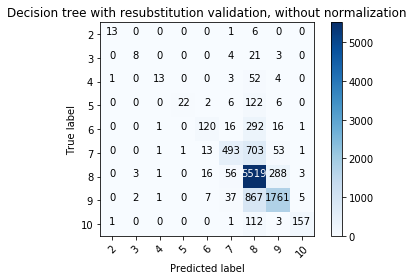

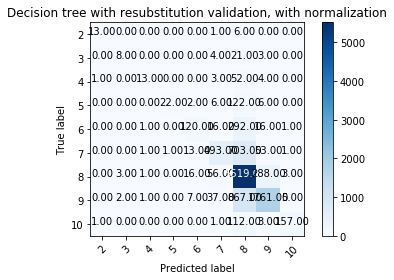

accuracy = 0.7479239712124008

Performance: 
             precision    recall  f1-score   support

          2       0.87      0.65      0.74        20
          3       0.62      0.22      0.33        36
          4       0.76      0.18      0.29        73
          5       0.96      0.14      0.24       158
          6       0.76      0.27      0.40       446
          7       0.80      0.39      0.52      1265
          8       0.72      0.94      0.81      5886
          9       0.83      0.66      0.73      2680
         10       0.94      0.57      0.71       274

avg / total       0.76      0.75      0.73     10838



In [6]:
#decision tree with resubstitution
from sklearn import model_selection
from sklearn.metrics import classification_report
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

class_names = ['2','3','4','5','6','7','8','9','10']
feature_names = ['Reviews','Size(M)','Installs','Price','Content Rating','Last Updated','Sentiment','Sentiment_Polarity','Sentiment_Subjectivity']

clf = tree.DecisionTreeClassifier(max_depth=15)
clf = clf.fit(X, y)
dt_pred = clf.predict(X) 


# Visualization  (tree->dot file->image file)
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=feature_names,  
                         class_names=class_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
(graph,) = pydot.graph_from_dot_data(dot_data)
graph.write_png('r_gtree.png')

print("Decision tree with resubstitution validation")
# Compute confusion matrix
cnf_matrix = confusion_matrix(y, dt_pred)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Decision tree with resubstitution validation, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Decision tree with resubstitution validation, with normalization')

plt.show()
print("accuracy = {0}\n".format(accuracy_score(y,dt_pred)))
print("Performance: ")
print(classification_report(y, dt_pred, target_names=class_names))


Random forest with resubstitution validation:


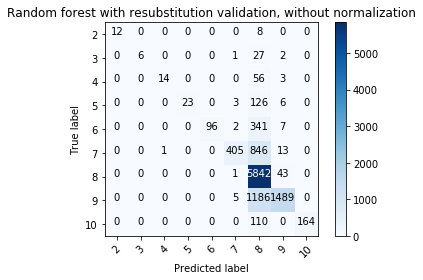

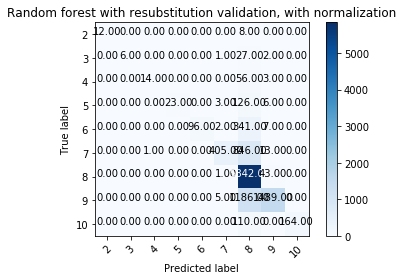

accuracy = 0.7428492341760472

Performance: 
             precision    recall  f1-score   support

          2       1.00      0.60      0.75        20
          3       1.00      0.17      0.29        36
          4       0.93      0.19      0.32        73
          5       1.00      0.15      0.25       158
          6       1.00      0.22      0.35       446
          7       0.97      0.32      0.48      1265
          8       0.68      0.99      0.81      5886
          9       0.95      0.56      0.70      2680
         10       1.00      0.60      0.75       274

avg / total       0.81      0.74      0.71     10838



In [7]:
#random forest with resubstitution
from scipy import stats
class_names = ['2','3','4','5','6','7','8','9','10']
feature_names = ['Reviews','Size(M)','Installs','Price','Content Rating','Last Updated','Sentiment','Sentiment_Polarity','Sentiment_Subjectivity']

flag=0
for i in range (0,9):
    for j in range (i+1,9):
        x_train = np.delete(X, np.s_[i,j], axis=1)
        dt = tree.DecisionTreeClassifier(max_depth=15)
        dt_pred = dt.fit(x_train, y).predict(x_train)
        if flag == 0:
            rf = dt_pred
            flag = 1
        else:
            rf = np.vstack((rf,dt_pred))


#merge results
rf_mode = stats.mode(rf)
rf_mode = rf_mode.mode[0]


print("Random forest with resubstitution validation:")
cnf_matrix = confusion_matrix(y,rf_mode)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Random forest with resubstitution validation, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Random forest with resubstitution validation, with normalization')

plt.show()
print("accuracy = {0}\n".format(accuracy_score(y,rf_mode)))
print("Performance: ")
print(classification_report(y, rf_mode, target_names=class_names))





Decision tree with k-fold cross validation:


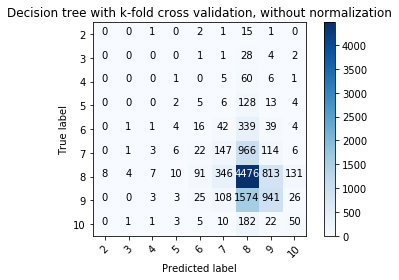

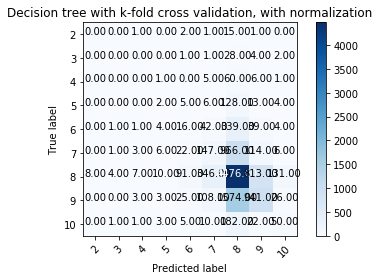

accuracy = 0.5196530725226056

Performance: 
             precision    recall  f1-score   support

          2       0.00      0.00      0.00        20
          3       0.00      0.00      0.00        36
          4       0.00      0.00      0.00        73
          5       0.07      0.01      0.02       158
          6       0.10      0.04      0.05       446
          7       0.22      0.12      0.15      1265
          8       0.58      0.76      0.66      5886
          9       0.48      0.35      0.41      2680
         10       0.22      0.18      0.20       274

avg / total       0.47      0.52      0.48     10838



In [8]:
#decision tree with k-fold cross validation
from sklearn.model_selection import cross_val_predict

clf_k = tree.DecisionTreeClassifier(max_depth=15)
#use the cross validation function, 'cv=20' means split the training data into 20 group
dt_k_pred = cross_val_predict(clf_k, X, y, cv=10)


print("Decision tree with k-fold cross validation:")
cnf_matrix = confusion_matrix(y, dt_k_pred)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Decision tree with k-fold cross validation, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Decision tree with k-fold cross validation, with normalization')

plt.show()
print("accuracy = {0}\n".format(accuracy_score(y,dt_k_pred)))
print("Performance: ")
print(classification_report(y, dt_k_pred, target_names=class_names))

Random forest with k-fold cross validation:


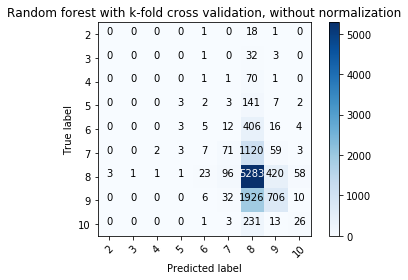

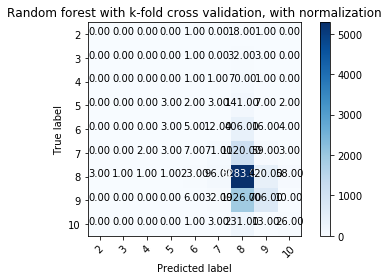

accuracy = 0.5622808636279757

Performance: 
             precision    recall  f1-score   support

          2       0.00      0.00      0.00        20
          3       0.00      0.00      0.00        36
          4       0.00      0.00      0.00        73
          5       0.30      0.02      0.04       158
          6       0.11      0.01      0.02       446
          7       0.33      0.06      0.10      1265
          8       0.57      0.90      0.70      5886
          9       0.58      0.26      0.36      2680
         10       0.25      0.09      0.14       274

avg / total       0.51      0.56      0.49     10838



In [9]:
#random forest with k-fold cross validation
#choose 7 feature everytime and create 36 decision trees

flag=0
for i in range (0,9):
    for j in range (i+1,9):
        x_sf = np.delete(X, np.s_[i,j], axis=1)
        dt = tree.DecisionTreeClassifier(max_depth=15)
        dt_pred = cross_val_predict(dt,x_sf,y,cv = 10)
        if flag == 0:
            rf_k = dt_pred
            flag = 1
        else:
            rf_k = np.vstack((rf_k,dt_pred))

#merge the prediction results from the above trees and find the mode of each column

rf_k_mode = stats.mode(rf_k)
rf_k_mode = rf_k_mode.mode[0]

print("Random forest with k-fold cross validation:")
cnf_matrix = confusion_matrix(y, rf_k_mode)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Random forest with k-fold cross validation, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Random forest with k-fold cross validation, with normalization')

plt.show()
print("accuracy = {0}\n".format(accuracy_score(y,rf_k_mode)))
print("Performance: ")
print(classification_report(y, rf_k_mode, target_names=class_names))